**Team Members**

Anindita Mitra (UIN - 659991967)

Sri Harshitha Karuturi (UIN 664151796)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
# Download Java Virtual Machine (JVM)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# Download Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz

!tar xf spark-3.3.1-bin-hadoop3.tgz

In [ ]:
#Set up the environment for Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/drive/MyDrive/spark-3.3.1-bin-hadoop3'

In [ ]:
# Install library for finding Spark
!pip install -q findspark

In [ ]:
#Install and import the library for locating Spark.
# Import the libary
import findspark
# Initiate findspark
findspark.init()
# Check the location for Spark
findspark.find()

'/content/drive/MyDrive/spark-3.3.1-bin-hadoop3'

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import all the required packages and create a spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import pyspark
from pyspark import SparkContext, SQLContext
import csv
from IPython.display import Image, HTML, display
import math
import matplotlib.pyplot as plt
%matplotlib inline
import re
import seaborn as sns
from pyspark.sql import SQLContext
# Import the required functions for ALS
from pyspark.ml.recommendation import ALS
# Hyperparameter tuning and cross-validation
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import Row
from pyspark.sql.functions import udf,col,when


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Netflix Recommendation Analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate() #This returns a SparkSession object if already exists, and creates a new one if not exist.

In [ ]:
#Read all data files into a spark dataframe
movies_data = spark.read.load(r"/content/drive/MyDrive/archive/movies.csv", format='csv', header = True)
ratings_data = spark.read.load("/content/drive/MyDrive/archive/ratings.csv", format='csv', header = True)
links_data = spark.read.load("/content/drive/MyDrive/archive/links.csv", format='csv', header = True)
tags_data = spark.read.load(r"/content/drive/MyDrive/archive/tags.csv", format='csv', header = True)

In [ ]:
from IPython.core.magic import register_line_cell_magic

#Limiting the number of lines that are being displayed
max_show_lines = 20         

@register_line_cell_magic
def sql(line, cell=None):
    "Return a Spark DataFrame for lazy evaluation of the sql. Use: %sql or %%sql"
    val = cell if cell is not None else line 
    return spark.sql(val)

@register_line_cell_magic
def sql_show(line, cell=None):
    "Execute sql and show the first max_show_lines lines. Use: %sql_show or %%sql_show"
    val = cell if cell is not None else line 
    return spark.sql(val).show(max_show_lines)

@register_line_cell_magic
def sql_display(line, cell=None):
    """Execute sql and convert results to Pandas DataFrame for pretty display or further processing.
    Use: %sql_display or %%sql_display"""
    val = cell if cell is not None else line 
    return spark.sql(val).limit(max_show_lines).toPandas() 

In [ ]:
movies_data.show(5)
ratings_data.show(5)
links_data.show(5)
tags_data.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

+------+-------+------+---------+---+
|userId|movieId|rating|timestamp|_c4|
+------+-------+------+---------+---+
|     1|      1|     4|964982703|215|
|     1|      3|     4|964981247| 52|
|     1|      6|     4|964982224|102|
|     1|     47|     5|964983815|203|
|     1|     50|     5|964982931|204|
+------+-------+------+---------+---+
only showing top 5 rows

+-------+------+-------+
|movieId|imdbId|ntflxid|
+-------+------+-------+
|      1|114709|    862|
|      2|113497|   8844|
|      3|113228

In [ ]:
print("Showing Movies data summary")
movies_data.describe().show()

print("Showing ratings data summary")
ratings_data.describe().show()

print("Showing Links data summary")
links_data.describe().show()

print("Showing Tags data summary")
tags_data.describe().show()

Showing Movies data summary
+-------+------------------+--------------------+------------------+
|summary|           movieId|               title|            genres|
+-------+------------------+--------------------+------------------+
|  count|              9742|                9742|              9742|
|   mean|42200.353623485935|                null|              null|
| stddev| 52160.49485443825|                null|              null|
|    min|                 1|"11'09""01 - Sept...|(no genres listed)|
|    max|             99992|À nous la liberté...|           Western|
+-------+------------------+--------------------+------------------+

Showing ratings data summary
+-------+------------------+----------------+------------------+--------------------+------------------+
|summary|            userId|         movieId|            rating|           timestamp|               _c4|
+-------+------------------+----------------+------------------+--------------------+------------------+
|  cou

## Exploratory Data Analysis

In [ ]:
#Calculate the number of ratings
print("Number of ratings: %i" % ratings_data.count())

#print a sample of ratings
print("Sample of ratings:")
ratings_data.show(5)

Number of ratings: 100836
Sample of ratings:
+------+-------+------+---------+---+
|userId|movieId|rating|timestamp|_c4|
+------+-------+------+---------+---+
|     1|      1|     4|964982703|215|
|     1|      3|     4|964981247| 52|
|     1|      6|     4|964982224|102|
|     1|     47|     5|964983815|203|
|     1|     50|     5|964982931|204|
+------+-------+------+---------+---+
only showing top 5 rows



In [ ]:
### finding null values in each columns in each dataframe
from pyspark.sql.functions import col,isnan, when, count
ratings_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ratings_data.columns]).show()
movies_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in movies_data.columns]).show()
links_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in links_data.columns]).show()
tags_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in tags_data.columns]).show()

+------+-------+------+---------+---+
|userId|movieId|rating|timestamp|_c4|
+------+-------+------+---------+---+
|     0|      0|     0|        0|  0|
+------+-------+------+---------+---+

+-------+-----+------+
|movieId|title|genres|
+-------+-----+------+
|      0|    0|     0|
+-------+-----+------+

+-------+------+-------+
|movieId|imdbId|ntflxid|
+-------+------+-------+
|      0|     0|      8|
+-------+------+-------+

+------+-------+---+---------+
|userId|movieId|tag|timestamp|
+------+-------+---+---------+
|     0|      0|  0|        0|
+------+-------+---+---------+



In [ ]:
#Get the number of users, total ratings & movies
num_of_user = ratings_data.select('userId').distinct().count()
print('Number of Users: {}'.format(num_of_user))

total_rating = ratings_data.select('rating').count()
print('Total number of ratings: {}'.format(total_rating))

num_of_movies = movies_data.select('movieId').distinct().count()
print('Number of Movies: {}'.format(num_of_movies))

Number of Users: 610
Total number of ratings: 100836
Number of Movies: 9742


In [ ]:
def get_mat_sparsity(ratings):
    # Count the total number of ratings in the dataset
    count_nonzero = ratings.select("rating").count()

    # Count the number of distinct userIds and distinct movieIds
    total_elements = ratings.select("userId").distinct().count() * ratings.select("movieId").distinct().count()

    # Divide the numerator by the denominator
    sparsity = (1.0 - (count_nonzero *1.0)/total_elements)*100
    print("The ratings dataframe is ", "%.2f" % sparsity + "% sparse.")
    
get_mat_sparsity(ratings_data)

The ratings dataframe is  98.30% sparse.


In [ ]:
# Join both the data frames to add movie data into ratings
movie_ratings = ratings_data.join(movies_data, ['movieId'], 'left')
movie_ratings.show()

+-------+------+------+---------+---+--------------------+--------------------+
|movieId|userId|rating|timestamp|_c4|               title|              genres|
+-------+------+------+---------+---+--------------------+--------------------+
|      1|     1|     4|964982703|215|    Toy Story (1995)|Adventure|Animati...|
|      3|     1|     4|964981247| 52|Grumpier Old Men ...|      Comedy|Romance|
|      6|     1|     4|964982224|102|         Heat (1995)|Action|Crime|Thri...|
|     47|     1|     5|964983815|203|Seven (a.k.a. Se7...|    Mystery|Thriller|
|     50|     1|     5|964982931|204|Usual Suspects, T...|Crime|Mystery|Thr...|
|     70|     1|     3|964982400| 55|From Dusk Till Da...|Action|Comedy|Hor...|
|    101|     1|     5|964980868| 23|Bottle Rocket (1996)|Adventure|Comedy|...|
|    110|     1|     4|964982176|237|   Braveheart (1995)|    Action|Drama|War|
|    151|     1|     5|964984041| 44|      Rob Roy (1995)|Action|Drama|Roma...|
|    157|     1|     5|964984100| 11|Can

In [ ]:
ratings_df = ratings_data.select("movieId", "userId", "rating")

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql.types import StructType

import re
#Create a UDF that extracts the release year from the title and returns the new title and year as a struct type.
def extract_year_fn(title):
    result = re.search("\(\d{4}\)", title)
    try:
        if result:
            group = result.group()
            year = group[1:-1]
            start_pos = result.start()
            title = title[:start_pos-1]
            return (title, year)
        else:
            return (title, None)
    except:
        print(title)

extract_year = udf(extract_year_fn, StructType([StructField("title", StringType(), True),StructField("release_date", StringType(), True)]))

In [ ]:
#Clean the movie data
movies_df = movies_data.select(
    "movieId", extract_year("title").title.alias("title"),\
    extract_year("title").release_date.alias("release_date"),\
   "genres")

#display the movie data after cleaning
print("Cleaned movie data:")
movies_df.show(5, truncate=False)

Cleaned movie data:
+-------+---------------------------+------------+-------------------------------------------+
|movieId|title                      |release_date|genres                                     |
+-------+---------------------------+------------+-------------------------------------------+
|1      |Toy Story                  |1995        |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji                    |1995        |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men           |1995        |Comedy|Romance                             |
|4      |Waiting to Exhale          |1995        |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II|1995        |Comedy                                     |
+-------+---------------------------+------------+-------------------------------------------+
only showing top 5 rows



In [ ]:
# Combine movies with links to get netflix id
movies = movies_df.join(links_data, movies_df.movieId == links_data.movieId)\
    .select(movies_df.movieId, movies_df.title, movies_df.release_date, movies_df.genres,links_data.imdbId, links_data.ntflxid)

print("number of movies data in movies dataset with ntflxid links: %i" % movies.count())
print("number of movies data in movies dataset: %i" % movies_df.count())
movies.show(5, truncate=False)

number of movies data in movies dataset with ntflxid links: 9742
number of movies data in movies dataset: 9742
+-------+---------------------------+------------+-------------------------------------------+------+-------+
|movieId|title                      |release_date|genres                                     |imdbId|ntflxid|
+-------+---------------------------+------------+-------------------------------------------+------+-------+
|1      |Toy Story                  |1995        |Adventure|Animation|Children|Comedy|Fantasy|114709|862    |
|2      |Jumanji                    |1995        |Adventure|Children|Fantasy                 |113497|8844   |
|3      |Grumpier Old Men           |1995        |Comedy|Romance                             |113228|15602  |
|4      |Waiting to Exhale          |1995        |Comedy|Drama|Romance                       |114885|31357  |
|5      |Father of the Bride Part II|1995        |Comedy                                     |113041|11862  |
+-------+

In [ ]:
ratings_df = ratings_df.withColumn("userId", ratings_df["userId"].cast(LongType()))
ratings_df = ratings_df.withColumn("movieId", ratings_df["movieId"].cast(LongType()))
ratings_df = ratings_df.withColumn("rating", ratings_df["rating"].cast(FloatType()))


In [ ]:
## creating view for each dataframe
movies_df.createOrReplaceTempView('movies')
ratings_df.createOrReplaceTempView('ratings')
tags_data.createOrReplaceTempView('tags')

In [ ]:
## average rating for categories
categories = spark.sql(
                   '''Select cte.category, count(*) as rate_num, avg(rating) as avg_rate
                      From movies m
                      Join
                        (Select movieId, title, explode(split(genres,'\\\\|')) as category
                        From movies) cte
                      on m.movieId=cte.movieId
                      Join ratings r on m.movieId=r.movieId
                      Group by cte.category
                      Order by 2 Desc''')

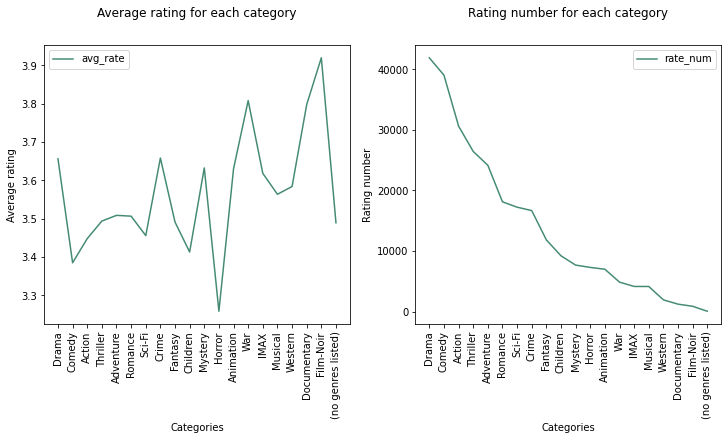

In [ ]:
#Plot graph to see average rating for each movie category & the nuber of ratings per movie category
fig, (ax1, ax2) = plt.subplots(figsize=(10,6), ncols=2, constrained_layout=True)
categories_p = categories.toPandas()

xticks = [cate[0] for cate in categories.select("category").collect()]

#Plot for Average rating per movie category
ax1.plot('category','avg_rate',data=categories_p, color='#458B74')
ax1.set_xlabel("Categories")
ax1.set_xticklabels(xticks,rotation=90)
ax1.set_ylabel("Average rating")
ax1.set_title("Average rating for each category", y=1.08)
ax1.legend()

#Plot for Number of ratings per movie category
ax2.plot('category','rate_num',data=categories_p, color='#458B74')
ax2.set_xlabel("Categories")
ax2.set_xticklabels(xticks,rotation=90)
ax2.set_ylabel("Rating number")
ax2.set_title("Rating number for each category", y=1.08)
ax2.legend()

In [ ]:
## number of movies for categories
categories_films = spark.sql(
                   '''Select cte.category, count(*) as num_movies
                      from (Select movieId, title, explode(split(genres,'\\\\|')) as category
                        From movies) cte
                      Group by cte.category
                      Order by 2 Desc''')

Text(0.5, 1.0, 'Top categories')

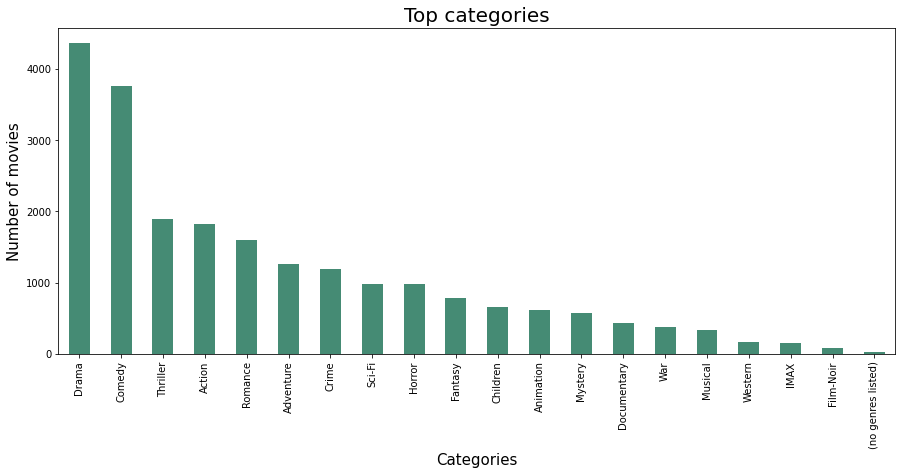

In [ ]:

categories_films.toPandas().plot(figsize = (15,6), kind = "bar", color = "#458B74",
                               x = "category", y = "num_movies", legend = False)

#Plot to display the number of each rating scores
plt.xlabel("Categories", fontsize = 15)
plt.ylabel("Number of movies", fontsize = 15)
plt.title("Top categories", fontsize = 20)


In [ ]:
#Get the rating scores
rating_scores = spark.sql(
                    '''Select rating, count(distinct movieId) as num_movies
                    From ratings
                    Group by rating
                    Order by 1''')

Text(0.5, 1.0, 'Number of movies for rating score')

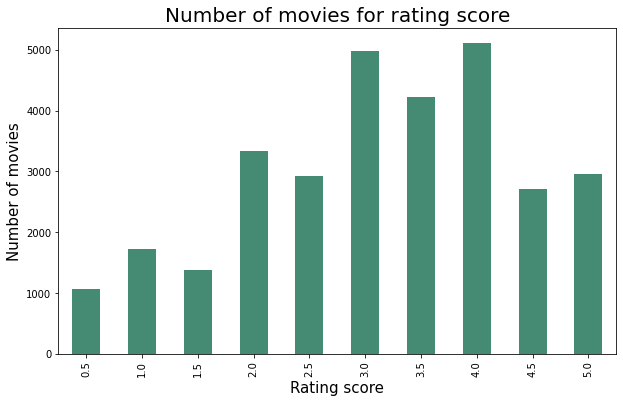

In [ ]:
rating_scores.toPandas().plot(figsize = (10,6), kind = "bar", color = "#458B74",
                               x = "rating", y = "num_movies", legend = False)

#Plot to display the number of each rating scores
plt.xlabel("Rating score", fontsize = 15)
plt.ylabel("Number of movies", fontsize = 15)
plt.title("Number of movies for rating score", fontsize = 20)

In [ ]:
%%sql_display

select max(release_date), min(release_date)
from movies

,max(release_date),min(release_date)
0,2018,1902


In [ ]:
%%sql_display

select distinct release_date
from movies
order by release_date

,release_date
0,None
1,1902
2,1903
3,1908
4,1915
5,1916
6,1917
7,1919
8,1920
9,1921


In [ ]:
#Get the rating scores
ReleaseDate1 = spark.sql(
                    '''select distinct release_date
from movies
order by release_date''')

In [ ]:
ReleaseDate1.show(100)

In [ ]:
#Get the rating scores
ReleaseDate = spark.sql(
                    '''Select release_date_group, count(distinct movieId) as num_movies
                    From (select *,
                         case when release_date<1970 then ' before 1970' 
                         when release_date between 1970 and 1979 then '1970s' 
                         when release_date between 1980 and 1989 then '1980s'
                         when release_date between 1990 and 1999 then '1990s' 
                         when release_date between 2000 and 2009 then '2000s' else 'after 2010' 
                         end as release_date_group
                        from movies)
                    Group by 1
                    Order by 1''')

Text(0.5, 1.0, 'Number of movies released each year')

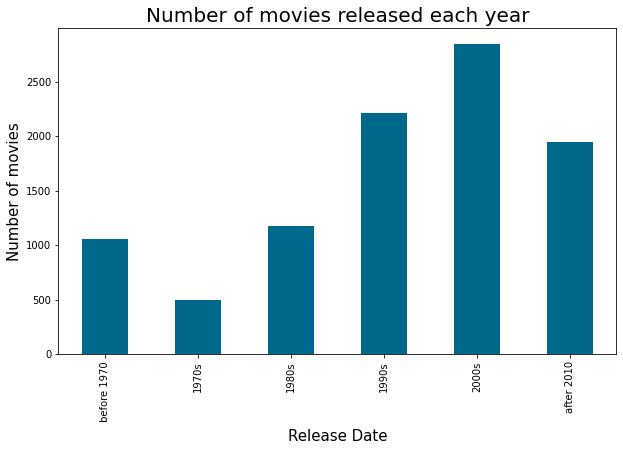

In [ ]:
ReleaseDate.toPandas().plot(figsize = (10,6), kind = "bar", color = "#00688B",
                               x = "release_date_group", y = "num_movies", legend = False)

#Plot to display the number of each rating scores
plt.xlabel("Release Date", fontsize = 15)
plt.ylabel("Number of movies", fontsize = 15)
plt.title("Number of movies released each year", fontsize = 20)

In [ ]:
avg_rating = spark.sql(
                  '''Select m.release_date, avg(rating) as average_rating
                From ratings r
                Join movies m on r.movieId=m.movieId
                where rating is not null
                Group by 1
                Order by 2 desc 
                limit 10''')

Text(0.5, 1.0, 'Top 10 years with highest ratings')

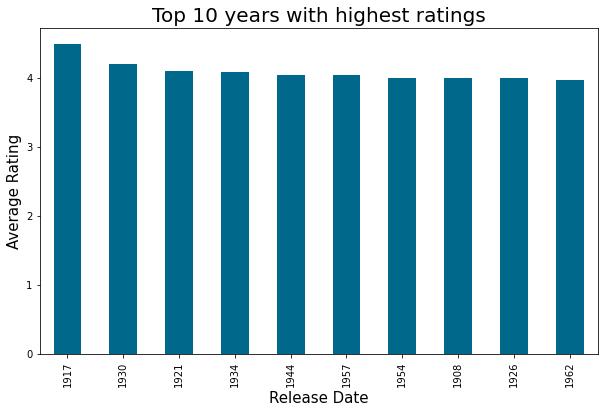

In [ ]:
avg_rating.toPandas().plot(figsize = (10,6), kind = "bar", color = "#00688B",
                               x = "release_date", y = "average_rating", legend = False)

#Plot to display the number of each rating scores
plt.xlabel("Release Date", fontsize = 15)
plt.ylabel("Average Rating", fontsize = 15)
plt.title("Top 10 years with highest ratings", fontsize = 20)

In [ ]:
%%sql_display

Select distinct tag
From tags

,tag
0,anime
1,hope
2,wrongful imprisonment
3,1970s
4,freaks
5,art
6,creativity
7,intelligent sci-fi
8,Heartwarming
9,lyrical


Exception ignored in: <function JavaWrapper.__del__ at 0x7f2f95a78710>
Traceback (most recent call last):
  File "/content/drive/MyDrive/spark-3.3.1-bin-hadoop3/python/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'ALS' object has no attribute '_java_obj'


(-0.5, 1599.5, 799.5, -0.5)

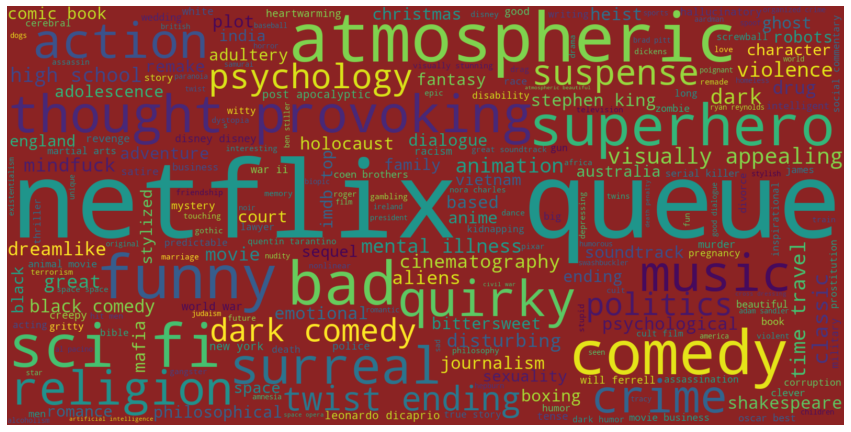

In [ ]:
from wordcloud import WordCloud, STOPWORDS
tags_pd = tags_data.toPandas()
text = tags_pd.tag[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)
#To build a wordcloud, we have to remove NULL values first:
tags_pd['tag'] = tags_pd['tag'].fillna(value="")
#Now let's add a string value instead to make our Series clean:
word_string=" ".join(tags_pd['tag'].str.lower())

#word_string
#And - plotting:

plt.figure(figsize=(15,15))
wc = WordCloud(background_color="#8B2323", stopwords = STOPWORDS, max_words=2000, max_font_size= 300,  width=1600, height=800, min_font_size = 10)
wc.generate(word_string)

plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), interpolation="bilinear")
plt.axis('off')


## Building ALS model

In [ ]:
sc = spark.sparkContext
sqlContext=SQLContext(sc)

/content/drive/MyDrive/spark-3.3.1-bin-hadoop3/python/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [ ]:
#Splitting the data into training and testing data with a 80:20 ratio
training_df, test_df = ratings_df.randomSplit([0.8,0.2])

In [ ]:
#Define the iterations 
iterations=10
regularization_parameter=0.1
rank=4
error=[]
err=0

In [ ]:
#Run the ALS model to get the RMSE score for rank= 5
#Creating ALS model and fitting data#
als = ALS(maxIter=iterations,
          regParam=regularization_parameter,
          rank=5,
          userCol="userId",
          itemCol="movieId",
          ratingCol="rating")

model=als.fit(training_df)


In [ ]:
#Generate predictions and evaluate rmse
predictions=model.transform(test_df)
new_predictions=predictions.filter(col('prediction')!=np.nan)

# Define evaluator and select rmse as metricName in evaluator.
evaluator=RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse=evaluator.evaluate(new_predictions)
print("Root Mean Square Error="+str(rmse))

Root Mean Square Error=1.0050297248617284


In [ ]:
#now feed both param_grid and evaluator into the crossvalidator including the ALS model. 
#I have chosen number of folds as 5.

# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [4,5,6,7,8,9,10]) \
            .addGrid(als.regParam, [.01, .05, .1, .5]) \
            .build()

# Build cross validation using CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# Confirm cv was built
print(cv)

#Fit cross validator to the 'train' dataset
model = cv.fit(training_df)


CrossValidator_d09417945720


In [ ]:
#Extract best model from the cv model above
best_model = model.bestModel

# Print best_model
print(type(best_model))

# Complete the code below to extract the ALS model parameters
print("**Best Model**")

# # Print "Rank"
print("  Rank:", best_model._java_obj.parent().getRank())

# Print "MaxIter"
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())

# Print "RegParam"
print("  RegParam:", best_model._java_obj.parent().getRegParam())

<class 'pyspark.ml.recommendation.ALSModel'>
**Best Model**
  Rank: 4
  MaxIter: 10
  RegParam: 0.01


In [ ]:
# View the predictions
test_predictions = best_model.transform(test_df)
new_test_predictions=test_predictions.filter(col('prediction')!=np.nan)

RMSE = evaluator.evaluate(new_test_predictions)
print(RMSE)

1.005029724861724


In [ ]:
#Display the predictions
predictions.show(n=10)

+-------+------+------+----------+
|movieId|userId|rating|prediction|
+-------+------+------+----------+
|      1|    78|   4.0| 3.9018793|
|      1|    91|   4.0| 3.6725109|
|      1|    96|   5.0| 3.9908664|
|      1|     5|   4.0|  4.077856|
|      1|    43|   5.0|  5.209178|
|      1|    50|   3.0| 3.0002434|
|      1|    98|   4.5|  4.193316|
|      1|    32|   3.0| 4.0741086|
|      1|    71|   5.0|  3.424359|
|      1|   124|   4.0|  4.118909|
+-------+------+------+----------+
only showing top 10 rows



In [ ]:
#Join the movie title to display with the predictions
predictions.join(movies_df,"movieId").select("userId","title","genres","prediction").show(15)

+------+--------------------+--------------------+----------+
|userId|               title|              genres|prediction|
+------+--------------------+--------------------+----------+
|   362|The Devil's Advocate|Drama|Mystery|Thr...| 3.8460474|
|   155|        Galaxy Quest|Adventure|Comedy|...|  3.745172|
|   368|Men in Black (a.k...|Action|Comedy|Sci-Fi| 3.0561771|
|   368|           King Kong|Action|Adventure|...| 3.4579997|
|   368|Hellbound: Hellra...|              Horror| 2.1598108|
|   115|The Devil's Advocate|Drama|Mystery|Thr...| 1.9926245|
|   101|        Galaxy Quest|Adventure|Comedy|...|  3.797411|
|   385|          Local Hero|              Comedy|  3.644411|
|   587|        Galaxy Quest|Adventure|Comedy|...|  4.148562|
|   577|Men in Black (a.k...|Action|Comedy|Sci-Fi|   3.61124|
|   384|       Out of Africa|       Drama|Romance|  3.465463|
|   606|Men in Black (a.k...|Action|Comedy|Sci-Fi| 3.3930366|
|   606|         Chinese Box|       Drama|Romance| 1.8967111|
|   409|

In [ ]:
#Display the predictions for a particular userid.
for_one_user = predictions.filter(col("userId")==78).join(movies_df,"movieId").join(links_data,"movieId").select("userId","title","genres","ntflxid","prediction")
for_one_user.show(5)

+------+--------------------+--------------------+-------+----------+
|userId|               title|              genres|ntflxid|prediction|
+------+--------------------+--------------------+-------+----------+
|    78|Indiana Jones and...|    Action|Adventure|     89| 3.7843382|
|    78|           Toy Story|Adventure|Animati...|    862| 3.9018793|
|    78|         Money Train|Action|Comedy|Cri...|  11517| 2.3606682|
|    78|         Matrix, The|Action|Sci-Fi|Thr...|    603|  3.990852|
|    78|Shawshank Redempt...|         Crime|Drama|    278| 4.2568674|
+------+--------------------+--------------------+-------+----------+
only showing top 5 rows



In [ ]:
#Open the top movies in the web browser of the netflix
import webbrowser 
link=("https://www.netflix.com/browse/genre/34399")
for movie in for_one_user.take(5):
    movieURL=link+str(movie.ntflxid)
    print(movie.title)
    webbrowser.open(movieURL)

Indiana Jones and the Last Crusade
Toy Story
Money Train
Matrix, The
Shawshank Redemption, The


#### Generate top 10 movie recommendations for each user


In [ ]:
userRecs = best_model.recommendForAllUsers(10)


In [ ]:
userRecs.printSchema()


root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- movieId: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [ ]:
userRecs.select("userId","recommendations.movieId").show(10,False)

+------+------------------------------------------------------------------+
|userId|movieId                                                           |
+------+------------------------------------------------------------------+
|1     |[6975, 86347, 82, 7842, 158872, 2290, 73569, 7982, 4902, 4794]    |
|3     |[53127, 132800, 2017, 3706, 70994, 6975, 31804, 4248, 49932, 195] |
|5     |[158872, 7982, 86347, 1503, 7842, 5080, 7748, 6952, 2290, 3993]   |
|6     |[7842, 158872, 2290, 86347, 1658, 6625, 7982, 1503, 7748, 5646]   |
|9     |[6975, 5080, 158872, 7982, 86347, 31804, 70994, 1503, 1014, 80126]|
|12    |[6975, 4617, 3706, 86347, 79428, 4248, 31804, 7841, 7991, 6264]   |
|13    |[2290, 7842, 1979, 58554, 158872, 59727, 37720, 1658, 6625, 3266] |
|15    |[158783, 3030, 8951, 6022, 86320, 2935, 25825, 3089, 2184, 2511]  |
|16    |[7841, 199, 3706, 97168, 3061, 6975, 3182, 932, 3379, 96004]      |
|17    |[6975, 158872, 7982, 86347, 7841, 31804, 7748, 3379, 1503, 4794]  |
+------+----

In [ ]:
#Generate top 10 movie recommendations for a specified set of users

##selecting specific users
users=ratings_df.select("userId").distinct().limit(5)

userSubsetRecs = best_model.recommendForUserSubset(users,10)

## Generate top 10 movie recommendations for each user
userSubsetRecs.select("userId","recommendations.movieId").show(10,False)

#### Generate top 10 user recommendations for each movie


In [ ]:
movieRecommends = best_model.recommendForAllItems(10)

In [ ]:
movieRecommends.printSchema()

root
 |-- movieId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- userId: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [ ]:
movieRecommends.select("movieId","recommendations.userId").show(10,False)

+-------+--------------------------------------------------+
|movieId|userId                                            |
+-------+--------------------------------------------------+
|1      |[53, 43, 543, 429, 344, 584, 337, 475, 485, 176]  |
|3      |[53, 43, 584, 77, 485, 344, 276, 542, 337, 389]   |
|5      |[43, 399, 574, 344, 584, 240, 485, 337, 243, 35]  |
|6      |[224, 276, 147, 12, 99, 543, 171, 37, 243, 574]   |
|9      |[485, 344, 77, 584, 407, 126, 539, 192, 283, 43]  |
|12     |[259, 399, 55, 393, 461, 224, 549, 598, 574, 138] |
|13     |[344, 485, 418, 584, 399, 426, 258, 126, 83, 43]  |
|15     |[399, 461, 598, 418, 138, 258, 574, 255, 224, 589]|
|16     |[53, 594, 276, 37, 452, 171, 543, 547, 31, 96]    |
|17     |[543, 22, 53, 423, 494, 594, 270, 329, 44, 252]   |
+-------+--------------------------------------------------+
only showing top 10 rows



In [ ]:
# Generate top 10 user recommendations for a specified set of movies
movies = ratings_df.select(als.getItemCol()).distinct().limit(3)
movieSubSetRecs = best_model.recommendForItemSubset(movies, 10)

movieSubSetRecs.select("movieId","recommendations.userId").show(10,False)

+-------+-------------------------------------------------+
|movieId|userId                                           |
+-------+-------------------------------------------------+
|474    |[53, 276, 147, 31, 37, 243, 452, 231, 112, 542]  |
|60756  |[37, 259, 147, 283, 112, 31, 55, 231, 549, 393]  |
|2529   |[258, 423, 344, 543, 418, 494, 485, 43, 399, 162]|
+-------+-------------------------------------------------+



## Recomendations with movie name and genre

In [ ]:
recommdn = best_model.recommendForAllUsers(10).toPandas()
recs_df = recommdn.recommendations.apply(pd.Series) \
            .merge(recommdn, right_index = True, left_index = True) \
            .drop(["recommendations"], axis = 1) \
            .melt(id_vars = ['userId'], value_name = "recommendation") \
            .drop("variable", axis = 1) \
            .dropna() 

recs_df = recs_df.sort_values('userId')

recs_df=pd.concat([recs_df['recommendation'].apply(pd.Series), recs_df['userId']], axis = 1)

recs_df.columns = ['MovieID','Rating', 'UserID']


In [ ]:
recs_df[recs_df["UserID"]==1]
[6975, 86347, 82, 7842, 158872, 2290, 73569, 7982, 4902, 4794]  

,MovieID,Rating,UserID
0,6975.0,7.328044,1
2440,158872.0,6.974326,1
3660,73569.0,6.598722,1
1830,7842.0,7.041638,1
4270,7982.0,6.588324,1
1220,82.0,7.125210,1
5490,4794.0,6.522273,1
610,86347.0,7.271550,1
4880,4902.0,6.524091,1
3050,2290.0,6.900546,1


In [ ]:
recs_df = recs_df.astype({'MovieID': 'int32'})


In [ ]:
recs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6100 entries, 0 to 2745
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MovieID  6100 non-null   int32  
 1   Rating   6100 non-null   float64
 2   UserID   6100 non-null   int32  
dtypes: float64(1), int32(2)
memory usage: 143.0 KB


In [ ]:
movies_pd = movies_df.toPandas()
movies_pd = movies_pd[["movieId","title", "genres"]]
movies_pd.head()

,movieId,title,genres
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,Adventure|Children|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,Comedy


In [ ]:
movies_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   object
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: object(3)
memory usage: 228.5+ KB


In [ ]:
movies_pd = movies_pd.astype({'movieId': 'int32'})
print(movies_pd.dtypes)

movieId     int32
title      object
genres     object
dtype: object


In [ ]:
## merging with movies dataframe to get movie title and genre of recommedated movies
recommendations = recs_df.merge(movies_pd, how='left', left_on="MovieID", right_on="movieId")

In [ ]:
recommendations[recommendations["UserID"]==1]


,MovieID,Rating,UserID,movieId,title,genres
0,6975,7.328044,1,6975,Funny Games,Drama|Horror|Thriller
1,158872,6.974326,1,158872,Sausage Party,Animation|Comedy
2,73569,6.598722,1,73569,Project A 2 ('A' gai wak juk jap),Action|Comedy|Crime
3,7842,7.041638,1,7842,Dune,Drama|Fantasy|Sci-Fi
4,7982,6.588324,1,7982,"Tale of Two Sisters, A (Janghwa, Hongryeon)",Drama|Horror|Mystery|Thriller
5,82,7.125210,1,82,Antonia's Line (Antonia),Comedy|Drama
6,4794,6.522273,1,4794,Opera,Crime|Horror|Mystery
7,86347,7.271550,1,86347,Louis C.K.: Chewed Up,Comedy
8,4902,6.524091,1,4902,"Devil's Backbone, The (Espinazo del diablo, El)",Drama|Fantasy|Horror|Thriller|War
9,2290,6.900546,1,2290,Stardust Memories,Comedy|Drama


In [ ]:
### checking the genre of recommendated movies with genre of user's watched movies
movie_ratings_df = movie_ratings.toPandas()
movie_ratings_df = movie_ratings_df[['movieId', 'userId', 'rating',  'title', 'genres']]

In [ ]:
movie_ratings_df.head()

,movieId,userId,rating,title,genres
0,1,1,4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,3,1,4,Grumpier Old Men (1995),Comedy|Romance
2,6,1,4,Heat (1995),Action|Crime|Thriller
3,47,1,5,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,50,1,5,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [ ]:
movie_ratings_df = movie_ratings_df.astype({'movieId': 'int32', 'userId': 'int32'})
movie_ratings_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   movieId  100836 non-null  int32 
 1   userId   100836 non-null  int32 
 2   rating   100836 non-null  object
 3   title    100836 non-null  object
 4   genres   100836 non-null  object
dtypes: int32(2), object(3)
memory usage: 3.1+ MB


In [ ]:
movie_ratings_df[movie_ratings_df['userId']==1]

,movieId,userId,rating,title,genres
0,1,1,4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,3,1,4,Grumpier Old Men (1995),Comedy|Romance
2,6,1,4,Heat (1995),Action|Crime|Thriller
3,47,1,5,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,50,1,5,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...
227,3744,1,4,Shaft (2000),Action|Crime|Thriller
228,3793,1,5,X-Men (2000),Action|Adventure|Sci-Fi
229,3809,1,4,What About Bob? (1991),Comedy
230,4006,1,4,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi
